In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [2]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 40 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

In [3]:
submission = pd.read_csv("../output/lgbm_bottom_v131.csv.gz")

In [4]:
infile = open("../input/encoders.pkl", "rb")
encoders = pickle.load(infile)
infile.close()

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
date_mapping = {f"F{i}": pd.to_datetime("2016-04-24")+pd.DateOffset(days=i) for i in range(1,29)}

forecast = (submission.loc[0:30489]
            .melt(id_vars=["id"], value_vars=[f"F{i}" for i in range(1,29)], var_name=["d"], value_name="fcst")
            .assign(id = lambda x: x.id.map(lambda x: x.replace("_validation","")))
           )
forecast["ds"] = forecast.d.map(date_mapping)
forecast["id"] = encoders["id"].transform(forecast.id)
forecast.drop("d", axis=1, inplace=True)

In [6]:
#mrg = pd.merge(data.loc[:, ["ds","id","item_id","dept_id","cat_id","store_id","state_id","y"]], 
#               forecast.loc[:, ["ds","ts_id","fcst"]], how=)

***
# Level 1

In [7]:
data_l1 = data.groupby(["ds"])["y"].sum().reset_index()

In [8]:
fcst_l1 = forecast.groupby(["ds"])["fcst"].sum().reset_index()

In [10]:
mrg = pd.merge(data_l1, fcst_l1, how="inner", on="ds")

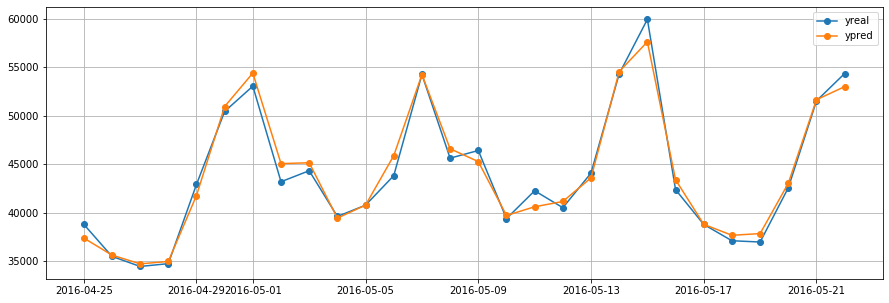

In [14]:
plt.figure(figsize=(15,5))
plt.plot_date(mrg.ds, mrg.y, "o-", label="yreal")
plt.plot_date(mrg.ds, mrg.fcst, "o-", label="ypred")
plt.grid()
plt.legend(loc="best")
plt.show()

In [19]:
min_date = data_l1.ds.min()
time = (data_l1.ds - min_date).apply(lambda x: x.days).values
values = data_l1.y.values

In [15]:
from supersmoother import SuperSmoother

In [101]:
help(SuperSmoother)

Help on class SuperSmoother in module supersmoother.supersmoother:

class SuperSmoother(supersmoother.smoother.LinearSmoother)
 |  SuperSmoother(alpha=None, period=None, primary_spans=(0.05, 0.2, 0.5), middle_span=0.2, final_span=0.05)
 |  
 |  SuperSmoother for nonparametric smoothing of scatter plots.
 |  
 |  SuperSmoother is an adaptive component-wise linear smoother, described
 |  in Friedman 1984 [1].
 |  
 |  Parameters
 |  ----------
 |  alpha : float (optional)
 |      If specified, the bass enhancement / smoothing level (0 < alpha < 10).
 |  period : float (optional)
 |      If specified, then assume the data is periodic with the given period.
 |  
 |  Other Parameters
 |  ----------------
 |  primary_spans : array_like, default=(0.05, 0.2, 0.5)
 |      The primary span values used for the smooth. Must be between 0 and 1.
 |      Only modify these if you know exactly what you're doing!
 |  middle_span : float (default = 0.2)
 |      The middle span value used for the algorith

In [291]:
from supersmoother import SuperSmoother
from tsforest.utils import make_time_range

class TrendModel():
    
    def __init__(self, window_length, alpha=None):
        self.window_length = window_length
        self.alpha = alpha
        self.primary_span_lower = 1
        self.primary_span_upper = 3
        self.middle_span = 3
        self.upper_span = 2
    
    def fit(self, data):
        min_date = data.ds.min()
        time_idx = (data.ds - min_date).apply(lambda x: x.days).values
        values = data.y.values 
        win = self.window_length / (max(time_idx)-min(time_idx)) 
        
        trend_model = SuperSmoother(
            alpha=self.alpha,
            primary_spans=(self.primary_span_lower * win,
                           win,
                           self.primary_span_upper * win),
            middle_span=self.middle_span * win,
            final_span=self.upper_span * win)
        trend_model.fit(time_idx, values)
        
        self.min_date = min_date
        self.trend_model = trend_model
    
    def predict(self, data):
        time_idx = (data.ds - self.min_date).apply(lambda x: x.days).values
        predictions = self.trend_model.predict(time_idx)
        return pd.DataFrame({"ds":data.ds.values, "trend":predictions})  

In [292]:
predict_tr = make_time_range("2016-04-25", "2016-05-22", "D")

In [297]:
tmodel1 = TrendModel(window_length=45, alpha=1)
tmodel1.fit(data_l1)
trend_dataframe1 = tmodel1.predict(predict_tr)

In [310]:
tmodel2 = TrendModel(window_length=30, alpha=1)
tmodel2.fit(data_l1.query("ds < '2016-04-25'"))
trend_dataframe2 = tmodel2.predict(predict_tr)

In [311]:
tmodel3 = TrendModel(window_length=50, alpha=1)
tmodel3.fit(pd.concat([data_l1.query("ds < '2016-04-25'"), fcst_l1.rename({"fcst":"y"}, axis=1)], ignore_index=True))
trend_dataframe3 = tmodel3.predict(predict_tr)

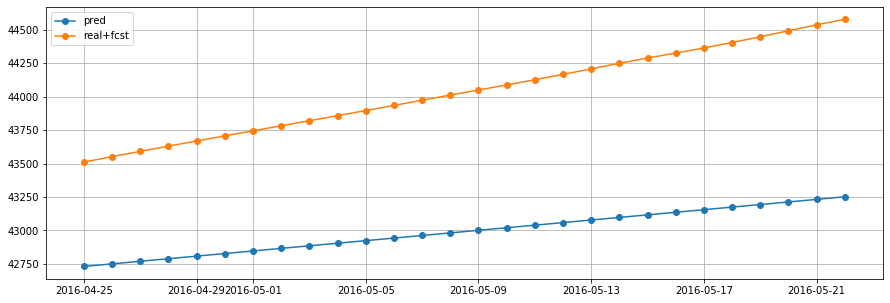

In [312]:
plt.figure(figsize=(15,5))
#plt.plot_date(trend_dataframe1.ds, trend_dataframe1.trend, "o-", label="real")
plt.plot_date(trend_dataframe2.ds, trend_dataframe2.trend, "o-", label="pred")
plt.plot_date(trend_dataframe3.ds, trend_dataframe3.trend, "o-", label="real+fcst")
plt.grid()
plt.legend(loc="best")
plt.show()

***

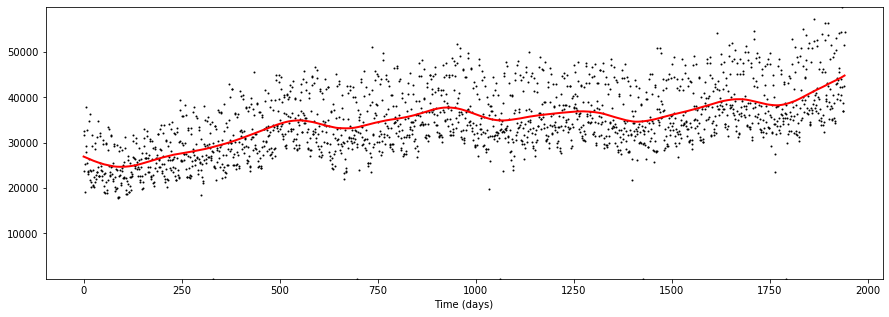

In [209]:
plt.figure(figsize=(15,5))
plt.scatter(data_l1.index.values, data_l1.y.values, color='black', s=1)
plt.plot(trend_dataframe.index.values, trend_dataframe.trend.values, color='red', linewidth=2)
plt.ylim(min(values), max(values))
plt.xlabel('Time (days)')
plt.show()

***